# Final Project: Coin Image Clustering

For the final project in my unsupervised machine learning course, I am clustering images of ancient coinage to see if it will come up with interesting and meaningful groups.

All the images for this project were previously downloaded from https://rpc.ashmus.ox.ac.uk/, an online database of Roman Provincial Coinage. These images were downloaded in the summer of 2022, so the current data on the website may be different. Each image represents a coin type that was minted by provincial cities in the Roman Empire. Only the images that come from coins that are results of searching "Tyche" in the search bar are included.

Tyche is the Greek word for fortune and was often personified and sometimes deified. I would like to see if this clustering method can identify different positions for her, such as standing, sitting, just a bust of her head, etc. Alternatively, it would be interesting if it could identify obverses and reverses (head and tails) of the coins.

In [34]:
# load packages
from PIL import Image
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import random

## Preprocessing

First, I need to get the images, which are all .jpgs in a folder on my computer, into pixel data in a numpy array.

In [2]:
# get path to image_folder
folder_path = '../../../../../Graduate Documents/SYRIOS Project - Summer 2022/Scripts/RPC_Tyche/rpc_tyche_images'

# initialize pixel storage
img_data = {}

# look through all images in the folder
for file_name in os.listdir(folder_path):
    if file_name.lower().endswith('.jpg'): # check if file is image
        coin_name = file_name.replace('.jpg', '') # store name
        img_path = os.path.join(folder_path, file_name)
        try:
            # open image
            img = Image.open(img_path)
            # convert to gray scale
            img = img.convert('L')
            # get all images as the same size (all are close to 250x250 pixels)
            img = img.resize((250,250))
            # get pixel data as a flat vector
            pixels = np.array(img).flatten()
            # store pixel data with name as key
            img_data[coin_name] = pixels
        except Exception as e:
            print(f"Error processing: {coin_name}: {e}")

In [3]:
# get data into a numpy matrix
# keep track of row order for img name

# initialize order tracker
img_order = []

# get dimensions for new matrix
pixel_vector_size = len(img_data['I_530_obv']) # dampling random image vector size
num_imgs = len(img_data)

# initialize new matrix
img_matrix = np.empty((num_imgs, pixel_vector_size), dtype = int)

# initialize row counter
ii = 0

for img_name, pixel_vector in img_data.items():
    # store name
    img_order.append(img_name)
    # replace matrix row
    img_matrix[ii, :] = pixel_vector
    # increase counter
    ii += 1

## Principal Component Analysis

This data is too big, so I'll conduct PCA to reduce its dimensionality. 

Note: There is no need to scale/standardize our data because each image has the same number of features represented in meaningful ways.

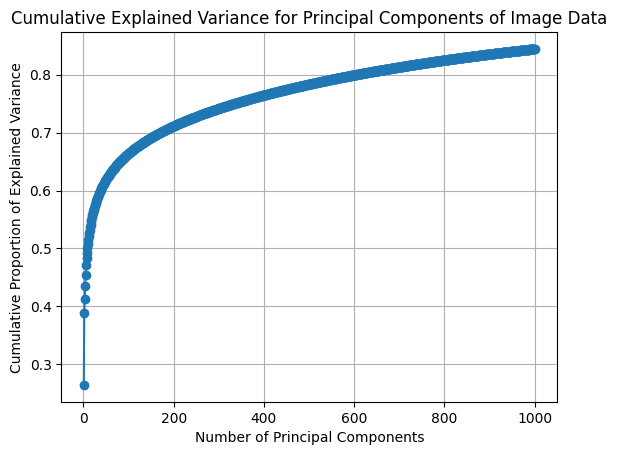

In [8]:
# perform PCA and inspect Proportion of Explained Variance

# initialize pca model
pca = PCA(n_components = 1000).fit(img_matrix) # calculates all principal components

# inspect cumulative variance explained
cum_pve = np.cumsum(pca.explained_variance_ratio_)

# plot proportion of explained variance
plt.figure()
plt.plot(range(1, len(cum_pve) + 1), cum_pve, marker = 'o', linestyle = '-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Explained Variance for Principal Components of Image Data')
plt.grid(True)
plt.show()

The 'elbow' on this graph looks like it occurs at about 100 principal components, so that will be the number we use for reducing our data.

In [48]:
# conduct pca with number of principal components chosen
reduced_img_matrix = PCA(n_components = 100).fit_transform(img_matrix)

## Hierarchical Clustering

I chose to use hierarchical clustering for this project with ward linkage. I will be creating models with 2 - 10 clusters then inspecting their silhouette scores. Once the best model has been chosen mathematically, I will then visually inspect some images assigned to each cluster to see if I can identify any of the reasons they were clustered that way.

In [49]:
# create multiple models and store their labels

# initialize storage
label_dict = {}

# create models
for num_clusters in range(2, 11): # making models with 2-10 clusters
    # create model
    clusters = AgglomerativeClustering(n_clusters = num_clusters, linkage = 'ward').fit(reduced_img_matrix)
    # get cluster labels
    labels = clusters.labels_
    # store labels
    label_dict[num_clusters] = labels

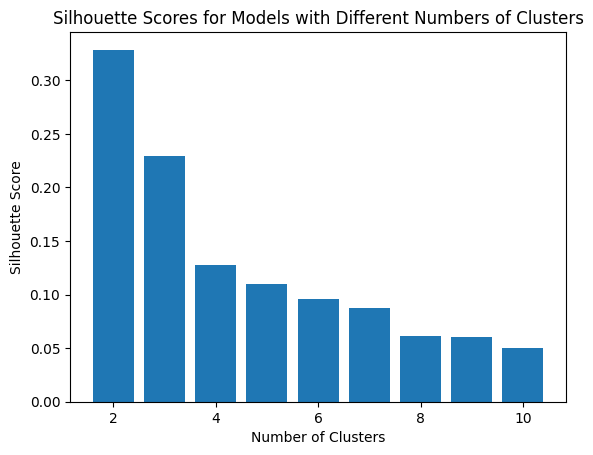

In [50]:
# get silhouette scores for each model

# initialize storage (by index)
silhouette_scores = [None] * 11

# calculate scores
for num_clusters, labels in label_dict.items():
    score = silhouette_score(reduced_img_matrix, labels)
    silhouette_scores[num_clusters] = score

# remove first 2 unnecessary indices (no models with 0 and 1 clusters)
silhouette_scores = silhouette_scores[2:11]

# plot scores
plt.figure()
plt.bar(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Models with Different Numbers of Clusters")
plt.show()

It looks like our model with only 2 clusters performs the best. Now let's visually inspect some of the coins for each cluster to see if we can determine any differences.

In [52]:
# create function for displaying 4x4 of 16 coin images

def display_cluster_sample(labels, cluster_num):
    # get indices of cluster 0 images
    cluster_indices = [index for index, label in enumerate(labels) if label == cluster_num]
    # randomly sample these image indices (ideally 16)
    if len(cluster_indices) >= 16:
        sample_size = 16
    else:
        sample_size = len(cluster_indices)
    cluster_sample = random.sample(cluster_indices, sample_size)
    # get image names in sample
    cluster_sample_names = [img_order[sample] for sample in cluster_sample]
    
    # initialize figure and counter for displaying images in an organized grid (4x4)
    plt.figure(figsize = (8, 8))
    fig_num = 1

    # open the images and display
    for img_name in cluster_sample_names:
        # get correct path to open image
        file_name = img_name + '.jpg'
        file_path = os.path.join(folder_path, file_name)
        # open image
        img = Image.open(file_path)
        # place in sublplot
        plt.subplot(4, 4, fig_num)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
        # update counter
        fig_num += 1

    plt.tight_layout()
    plt.show()

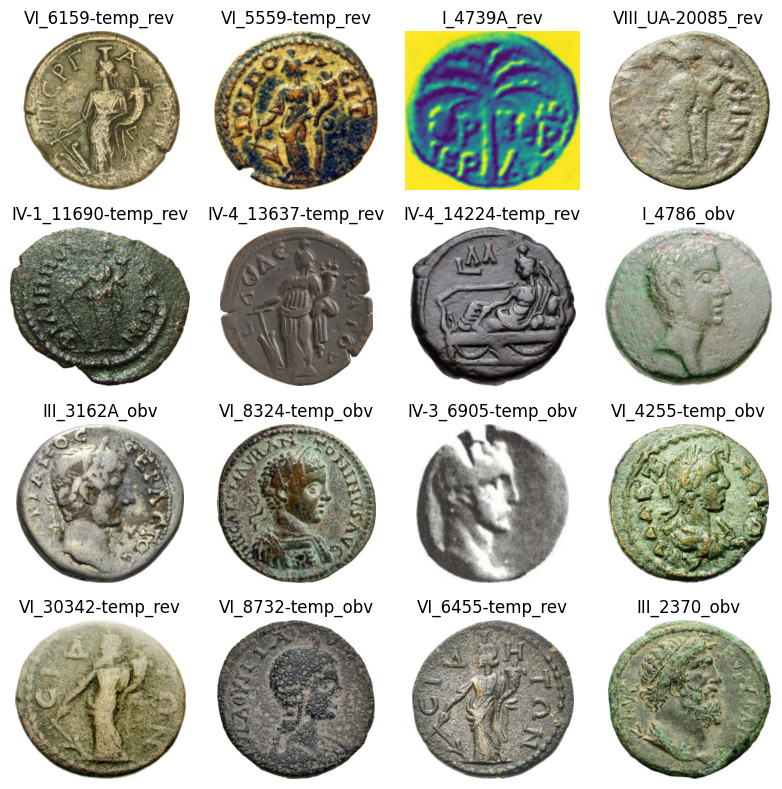

In [53]:
# first we'll print images from cluster 0

# retrieve a sample of image names from cluster 0
# get 2-cluster model labels
two_cluster_labels = label_dict[2]

# now display cluster 0
display_cluster_sample(two_cluster_labels, 0)

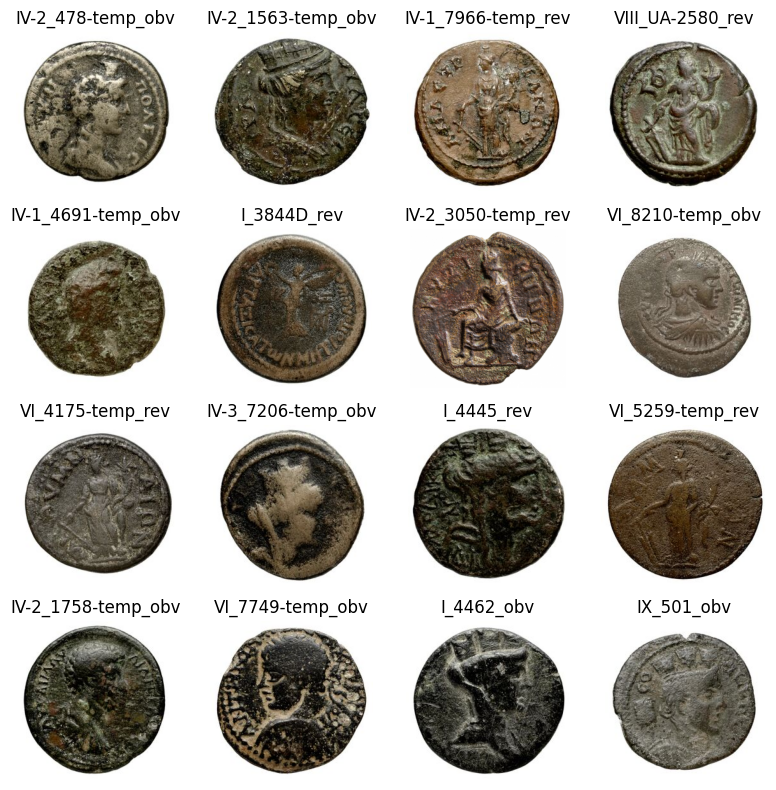

In [54]:
# display cluster 1 samples
display_cluster_sample(two_cluster_labels, 1)

It looks like the main difference between the first and second clusters is the darkness of the coin image. Essentially, cluster 0 shows images with high relief and cluster 1 shows those with low contrast. Funnily enough, this clustering method is not useful for telling anything about the information on the coins but rather shows us which images may need to be replaced for better viewing.

## Density-Based Spatial Clustering of Applications with Noise

Since the hierarchical clustering results were not very meaningful, we're going to try DBSCAN, which is known for handling high dimensionality and odd cluster shapes well.

Silhouette Score: 0.04976787158143732
{0}
Cluster 0 Sample


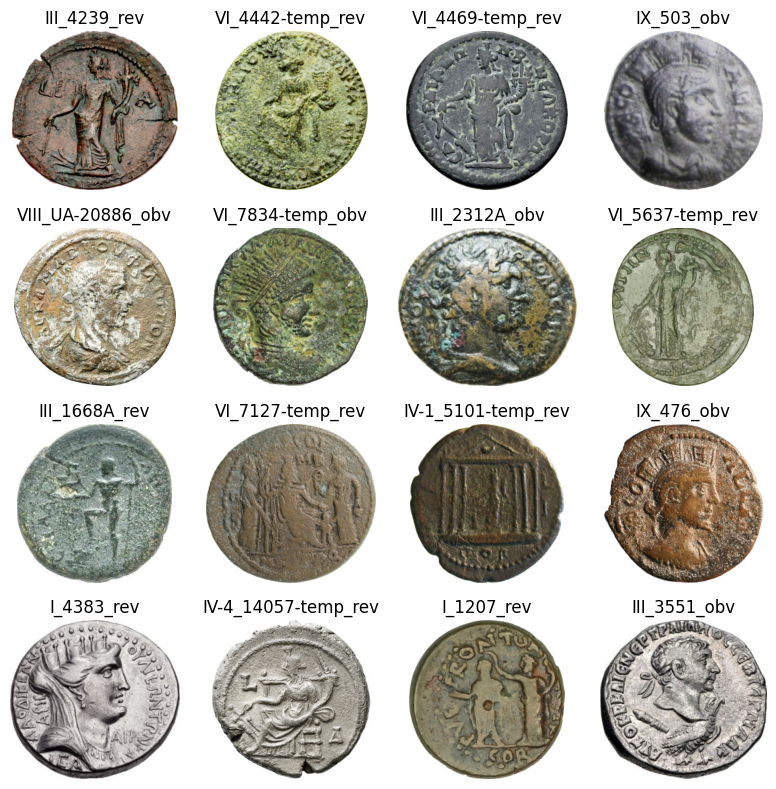

In [73]:
# create DBSCAN model
dbscan = DBSCAN(eps = 100000000000000000000000000) # we have a lot of coin images!
dbscan.fit(reduced_img_matrix)

# get number of clusters assigned
num_clusters = len(set(dbscan.labels_))

# calculate silhouette score
score = silhouette_score(reduced_img_matrix, labels)
print(f"Silhouette Score: {score}")

print(set(dbscan.labels_))

# show random sample of 16 images for each cluster
for ii in range(num_clusters):
    print(f"Cluster {ii} Sample")
    display_cluster_sample(dbscan.labels_, ii)

After much trial and error with changing epsilon, the main parameter of DBSCAN, it seems the data are too similar to be clustered into different groups with this method.

## Conclusion

After testing hierarchical clustering and DBSCAN, hierarchical clustering was the only method that provided meaningful results. While I initially sought out to divide the coin images based on the depictions they held, clustering only divided images based on their contrast. Therefore, this method cannot be used for archaeological interpretation, it can be used for evaluating the quality of the documentation provided.